In [2]:
import pandas as pd
import requests as r
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import rasterio
import pystac_client
import planetary_computer

sys.path.append(os.path.abspath('..'))
from datetime import *     
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [7]:
import data_utils.vis as vis
import data_utils.data_helpers as data

### 1. Setting up elevation data per parcel using Python GIS Libraries

In [35]:
df_parcels = pd.read_csv('data/parcels/preprocessed_parcels_data.csv')

In [4]:
# pulling elevation data for all available properties 

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

tybee_bbox = [-80.86, 32.00, -80.83, 32.05]

search = catalog.search(
    collections=["3dep-seamless"],
    bbox=tybee_bbox
)

items = list(search.items()) 

if not items:
    print("CRITICAL ERROR: Could not find any 3DEP data for Tybee Island.")
else:
    dem_asset = items[0].assets["data"] 
    dem_href = dem_asset.href
    print(f"Found data file: {dem_href}")
    print(f"Opening cloud data file and sampling {len(df_parcels)} properties...")
    
    coordinates = list(zip(df_parcels['Longitude'], df_parcels['Latitude']))
    
    elevations = []
    
    with rasterio.open(dem_href) as src:
        print("Querying elevations...")
        results_generator = src.sample(coordinates)
        
        for result in tqdm(results_generator, total=len(coordinates)):
            elevation_val = result[0]
            if elevation_val < -9000:
                elevations.append(pd.NA)
            else:
                elevations.append(elevation_val)

    df_parcels['Elevation'] = elevations
    print(df_parcels[['Latitude', 'Longitude', 'Elevation']].head())
    print(df_parcels['Elevation'].describe())

Found data file: https://ai4edataeuwest.blob.core.windows.net/3dep/Elevation/13/TIFF/n33w081/USGS_13_n33w081.tif?st=2025-11-08T22%3A11%3A31Z&se=2025-11-09T22%3A56%3A31Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-11-09T19%3A19%3A29Z&ske=2025-11-16T19%3A19%3A29Z&sks=b&skv=2025-07-05&sig=lRPz01215doJplsZ6syBo/2sSFQqN7UVRJSL7Cg92LA%3D
Opening cloud data file and sampling 12137 properties...
Querying elevations...


100%|██████████| 12137/12137 [00:00<00:00, 13472.01it/s]

    Latitude  Longitude Elevation
0  32.024256 -80.847243  5.255017
1  32.024256 -80.847243  5.255017
2  32.024256 -80.847243  5.255017
3  32.024256 -80.847243  5.255017
4  32.025120 -80.848704  1.375379
count     8570.000000
unique     110.000000
top          2.803348
freq      1142.000000
Name: Elevation, dtype: float64


There are 3000+ rows that have a NaN value for the elevation field. Plotting the coordinates of these rows against a random representative sample of rows with non-NaN elevation fields, we have the following figure (blue represents non-Nan, red represents Nan).

![Flood Risk Forecast Plot](resources/elevation.png)

In [5]:
# clean up the dataframe by imputing missing values
df_parcels['Elevation'].fillna(0, inplace=True)
df_parcels.head()

/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_84906/3062823188.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_parcels['Elevation'].fillna(0, inplace=True)
/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_84906/3062823188.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_parce

,Property Address,Year,Fair Market Value,Sale Price,Acres,Year Built,Latitude,Longitude,Elevation
0,37.0 PULASKI ST TYBEE ISLAND GA 31328.0 37 PUL...,2023,1330300.0,0.0,0.15,2003.0,32.024256,-80.847243,5.255017
1,33.0 PULASKI ST TYBEE ISLAND GA 31328.0 33 PUL...,2023,1347300.0,0.0,0.82,1936.0,32.024256,-80.847243,5.255017
2,29.0 PULASKI ST TYBEE ISLAND GA 31328.0 29 PUL...,2023,367400.0,0.0,0.59,1932.0,32.024256,-80.847243,5.255017
3,27.0 PULASKI ST TYBEE ISLAND GA 31328.0 27 PUL...,2023,838600.0,0.0,0.73,1932.0,32.024256,-80.847243,5.255017
4,6.0 NORTHSHORE DR TYBEE ISLAND GA 31328.0 6 NO...,2023,879500.0,0.0,0.04,1991.0,32.025120,-80.848704,1.375379


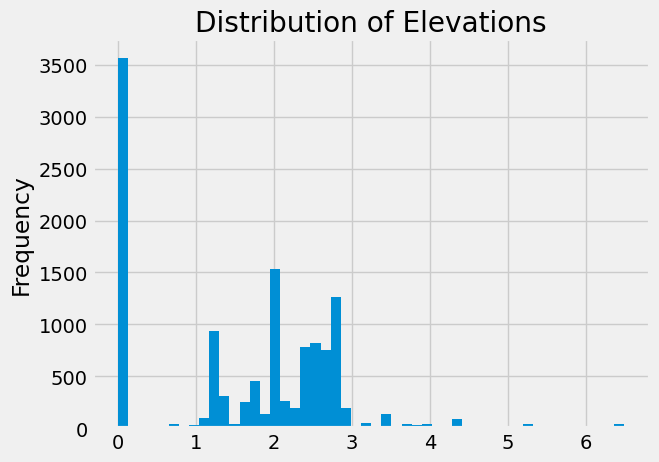

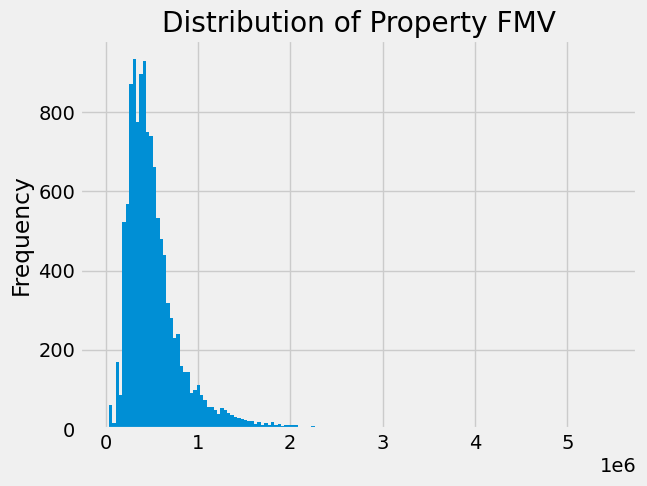

In [6]:
# visualizations 
vis.visualize_histogram(df_parcels['Elevation'], bins=50, title="Distribution of Elevations")
vis.visualize_histogram(df_parcels['Fair Market Value'], bins=150, title="Distribution of Property FMV")

### 2. Setting up Water Level Data from SECOORA Data Feeds

Let us clean and process the data for the SECOORA water level feeds, from which we can engineer informative flood-related features to append to our parcel data. Plotting the time-series after filtering for outliers due to sensor observation noise, we'll see that there is a structural break in the time series data, attributable to a change in the sensor location and elevation around that date. 

In [31]:
df_water = pd.read_csv(
    'data/water_level/full_historical_secoora.csv', 
    skiprows=[1], 
    parse_dates=['time']
)

In [32]:
df_water = df_water.drop(columns=[
    'water_surface_above_station_datum',
    'water_surface_above_navd88_surveyed_navd88_qc_agg',
    'water_surface_above_station_datum_qc_agg',
    'z'
])

df_water = df_water.dropna()
df_water = df_water.reset_index()
df_water = df_water.drop(columns=['index',])
df_water = data.remove_outliers_by_range(
    df_water, 
    'water_surface_above_navd88_surveyed_navd88', 
    plausible_min= -4, 
    plausible_max= 4
)

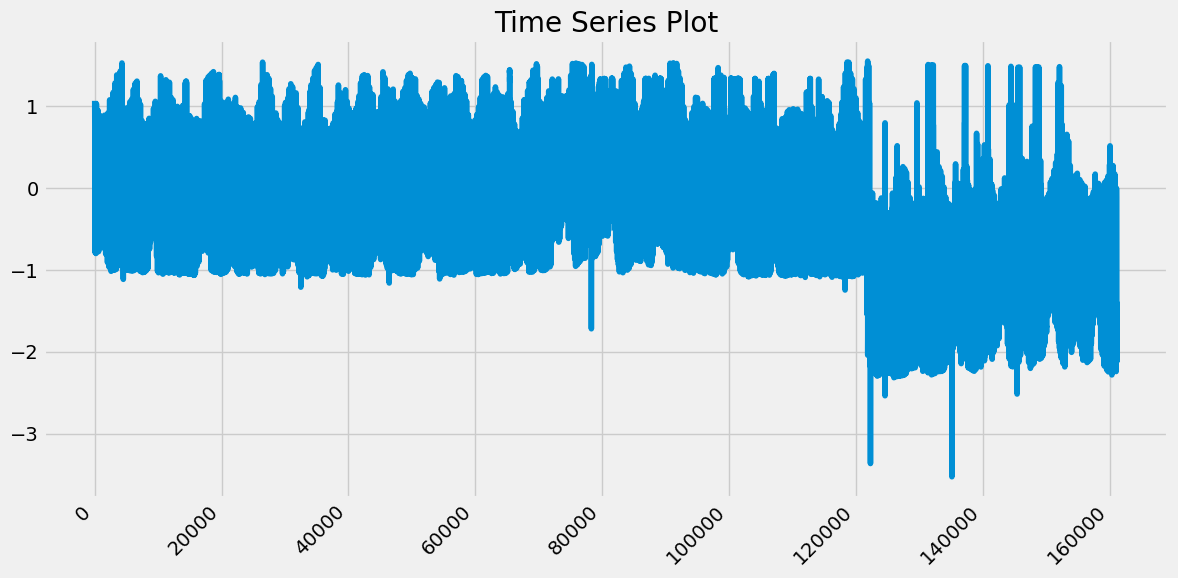

In [33]:
vis.visualize_time_series(df_water['water_surface_above_navd88_surveyed_navd88'])

In [34]:
df_water = df_water.copy() 

try:
    search_start_loc = 115000 
    search_end_loc = 125000
    
    if len(df_water) < search_end_loc:
        print("Warning: Data is shorter than the hard-coded search window.")
        search_end_loc = len(df_water) - 1

    search_slice = df_water.iloc[search_start_loc:search_end_loc]
    change_index = search_slice['water_surface_above_navd88_surveyed_navd88'].diff().idxmin()
    change_loc = df_water.index.get_loc(change_index)
    
    print(f"Sensor change detected at index: {change_index} (Row #{change_loc})")
    buffer = 50 
    mean_before = df_water['water_surface_above_navd88_surveyed_navd88'].iloc[change_loc - 1000 - buffer : change_loc - buffer].mean()
    mean_after = df_water['water_surface_above_navd88_surveyed_navd88'].iloc[change_loc + buffer : change_loc + 1000 + buffer].mean()
    
    shift_value = mean_before - mean_after
    
    print(f"Calculated shift value: {shift_value:.4f} (Your estimate was ~1.0)")
    df_water.loc[change_index:, 'water_surface_above_navd88_surveyed_navd88'] += shift_value
    
    print("Data shifted successfully.")

except Exception as e:
    print(f"An error occurred. Error: {e}")

Sensor change detected at index: 121849 (Row #121834)
Calculated shift value: 1.0950 (Your estimate was ~1.0)
Data shifted successfully.


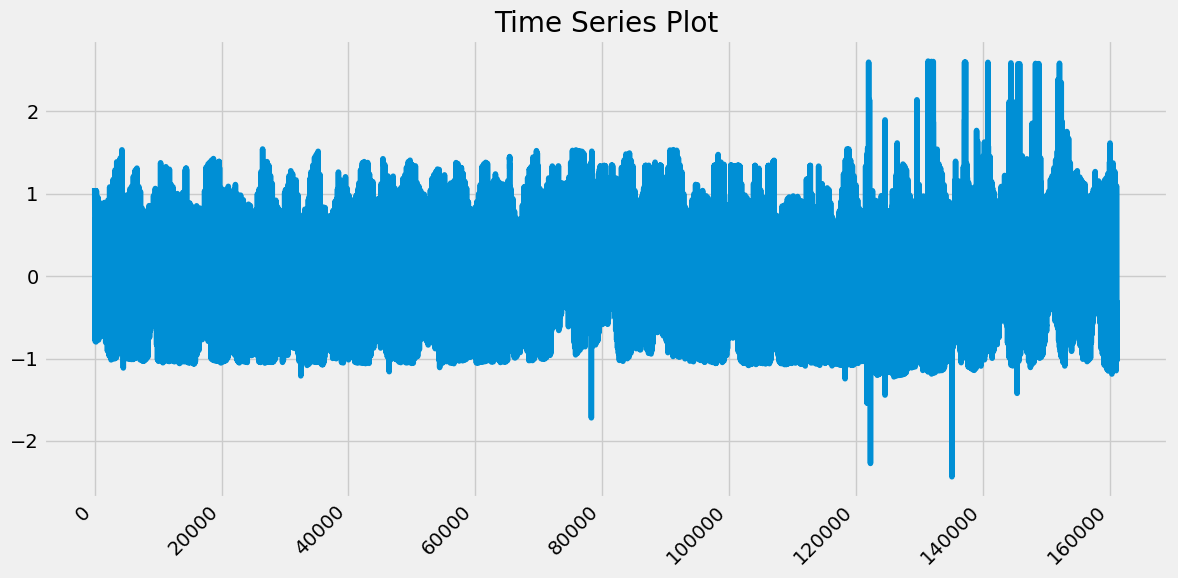

In [35]:
vis.visualize_time_series(df_water['water_surface_above_navd88_surveyed_navd88'])